In [1]:
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as Tv
import torchaudio
import torchaudio.transforms as Ta
from PIL import Image
from torch.nn import functional as F

In [2]:
!pip install av


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install librosa


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [4]:
class CombinedDataset(Dataset):
    def __init__(self, root_dir, num_frames_per_clip=8, spec_mean=0.0, spec_std=1.0,max_samples=50):
        """
        Args:
            root_dir (str): Path to the dataset directory.
            num_frames_per_clip (int): Number of frames to sample per video.
            spec_mean (float): Mean for spectrogram normalization.
            spec_std (float): Std for spectrogram normalization.
        """
        self.sampling_frequency = 16000  # Fixed sampling frequency for audio

        self.root_dir = root_dir
        self.num_frames_per_clip = num_frames_per_clip
        self.spec_mean = spec_mean
        self.spec_std = spec_std
        self.max_samples = max_samples

        self.visual_transforms = Tv.Compose([
            Tv.ToTensor(),
            Tv.ConvertImageDtype(torch.float32),
            Tv.Resize((224, 224)),  # Resize frames to 224x224 for ViT
            Tv.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.mel = Ta.MelSpectrogram(
            sample_rate=self.sampling_frequency,
            n_fft=400,
            win_length=400,
            hop_length=160,
            n_mels=128,
        )
        self.a2d = Ta.AmplitudeToDB()

        self.data = self._load_data()

    def _load_data(self):
        """
        Parse the dataset directory structure.
        Returns a list of tuples (video_path, audio_path, label).
        """
        data = []
        video_files_dir = os.path.join(self.root_dir, "video")
        audio_files_dir = os.path.join(self.root_dir, "audio")
        class_dirs = os.listdir(video_files_dir)

        for class_idx, class_dir in enumerate(class_dirs):
            video_dir = os.path.join(video_files_dir, class_dir)
            audio_dir = os.path.join(audio_files_dir, class_dir)
            video_files = glob.glob(os.path.join(video_dir, "*.mp4"))
            audio_files = glob.glob(os.path.join(audio_dir, "*.wav"))
            
            video_files = video_files[:self.max_samples]
            audio_files = audio_files[:self.max_samples]
            
            for vf, af in zip(video_files, audio_files):
                id = os.path.basename(vf).split('.')[0]
                data.append((vf, af, class_idx, id))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path, audio_path, label, id = self.data[idx]

        # Load video frames
        video_frames = self._load_video_as_frames(video_path)
        video_frames = self.transform_video(video_frames)

        # Load audio spectrogram
        audio_spectrogram = self._load_audio(audio_path)
        audio_spectrogram = self.transform_audio(audio_spectrogram)

        return {"video": video_frames, "audio": audio_spectrogram, "label": label, "id": id}

    def _load_video_as_frames(self, video_path):
        """
        Load video as frames, sample a fixed number of frames, and stack them.
        """
        from torchvision.io import read_video
        video, _, _ = read_video(video_path, pts_unit='sec')  # Use pts_unit='sec' to avoid warning
        frame_count = video.shape[0]
        indices = np.linspace(0, frame_count - 1, self.num_frames_per_clip, dtype=int)
        sampled_frames = video[indices]
        return sampled_frames  # Shape: (T, H, W, C)

    def _load_audio(self, audio_path):
        """
        Load audio as waveform, process it into a spectrogram, and normalize.
        """
        waveform, sample_rate = torchaudio.load(audio_path, normalize=True)
        # Use mono audio (left channel if stereo)
        waveform = waveform[0]
        # Resample if necessary
        if sample_rate != self.sampling_frequency:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sampling_frequency)
        # Normalize waveform
        waveform = (waveform - torch.mean(waveform)) / (torch.std(waveform) + 1e-6)
        # Generate mel spectrogram and convert amplitude to decibels
        spectrogram = self.a2d(self.mel(waveform))
        # Normalize spectrogram.
        spectrogram = (spectrogram - self.spec_mean) / self.spec_std
        spectrogram = spectrogram.type(torch.float32)

        # Resize spectrogram to 128x128 for AST input
        spectrogram = spectrogram.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions: (1, 1, n_mels, time_steps)
        spectrogram = F.interpolate(spectrogram, size=(128, 128), mode='bilinear', align_corners=False)
        spectrogram = spectrogram.squeeze(0)  # Remove batch and channel dimensions: (128, 128)
        return spectrogram

    def transform_video(self, video_frames):
        """
        Apply visual transformations to video frames.
        """
        transformed_frames = []
        for frame in video_frames:
            frame = frame.numpy()  # Convert to numpy array
            frame = (frame * 255).astype(np.uint8)  # Scale to 0-255
            if frame.shape[-1] == 1:  # Handle grayscale frames
                frame = frame.squeeze(-1)  # Remove the last dimension
            frame = Image.fromarray(frame, mode='RGB' if frame.ndim == 3 else 'L')  # Convert to PIL Image
            frame = self.visual_transforms(frame)  # Apply transformations (including resize to 224x224)
            transformed_frames.append(frame)
        return torch.stack(transformed_frames, 0).type(torch.float32)

    def transform_audio(self, spectrogram):
        """
        Apply audio transformations to spectrogram.
        """
        return spectrogram


In [5]:
# Example usage
dataset = CombinedDataset(
    root_dir="final_dataset"
)

# Check dataset size
print(len(dataset))

# Fetch a sample
sample = dataset[0]

# See dimensions
print(sample["video"].shape)
print(sample["audio"].shape)
print(sample["label"])

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


2600
torch.Size([8, 3, 224, 224])
torch.Size([1, 128, 128])
0


In [6]:
import torchaudio
print(torchaudio.list_audio_backends())

['soundfile']


In [7]:
import torch
import torch.nn as nn

class VanillaEncoder(nn.Module):
    def __init__(self, num_latents, spec_enc, rgb_enc):
        super(VanillaEncoder, self).__init__()

        # SPEC
        # Attention Layer
        self.spec_norm1 = spec_enc.norm1
        self.spec_attn = spec_enc.attn
        # Feed Forward Layers
        self.spec_norm2 = spec_enc.norm2
        self.spec_mlp = spec_enc.mlp

        # RGB
        # Attention Layer
        self.rgb_norm1 = rgb_enc.norm1
        self.rgb_attn = rgb_enc.attn
        # Feed Forward Layers
        self.rgb_norm2 = rgb_enc.norm2
        self.rgb_mlp = rgb_enc.mlp

        # Latents
        self.num_latents = num_latents
        self.latents = nn.Parameter(torch.empty(1,num_latents,768).normal_(std=0.02))
        self.scale_a = nn.Parameter(torch.zeros(1))
        self.scale_v = nn.Parameter(torch.zeros(1))


    def attention(self,q,k,v): # requires q,k,v to have same dim
        B, N, C = q.shape
        attn = (q @ k.transpose(-2, -1)) * (C ** -0.5) # scaling
        attn = attn.softmax(dim=-1)
        x = (attn @ v).reshape(B, N, C)
        return x
    
    # Latent Fusion
    def fusion(self, audio_tokens, visual_tokens):
        # shapes
        BS = audio_tokens.shape[0]
        # concat all the tokens
        concat_ = torch.cat((audio_tokens,visual_tokens),dim=1)
        # cross attention (AV -->> latents)
        fused_latents = self.attention(q=self.latents.expand(BS,-1,-1), k=concat_, v=concat_)
        # cross attention (latents -->> AV)
        audio_tokens = audio_tokens + self.scale_a * self.attention(q=audio_tokens, k=fused_latents, v=fused_latents)
        visual_tokens = visual_tokens + self.scale_v * self.attention(q=visual_tokens, k=fused_latents, v=fused_latents)
        return audio_tokens, visual_tokens
    
    def forward(self, x, y):

        # Bottleneck Fusion
        x,y = self.fusion(x,y)

        # Attn skip connections
        x = x + self.spec_attn(self.spec_norm1(x))
        y = y + self.rgb_attn(self.rgb_norm1(y))

        # FFN + skip conections
        x = x + self.spec_mlp(self.spec_norm2(x))
        y = y + self.rgb_mlp(self.rgb_norm2(y))
        return x,y

        
#####################################################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################

class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)

class AdaptFormer(nn.Module):
    def __init__(self, num_latents, dim, spec_enc, rgb_enc):
        super(AdaptFormer, self).__init__()

        # SPEC
        # Attention Layer
        self.spec_norm1 = spec_enc.norm1
        self.spec_attn = spec_enc.attn
        # Feed Forward Layers
        self.spec_norm2 = spec_enc.norm2
        self.spec_mlp = spec_enc.mlp

        # RGB
        # Attention Layer
        self.rgb_norm1 = rgb_enc.norm1
        self.rgb_attn = rgb_enc.attn
        # Feed Forward Layers
        self.rgb_norm2 = rgb_enc.norm2
        self.rgb_mlp = rgb_enc.mlp

        # Adapter params
        self.act = QuickGELU()
        self.dropout = nn.Dropout(0.1)
        self.dim = dim

        # Spectrogram
        self.spec_down = nn.Linear(768, dim)
        self.spec_up = nn.Linear(dim, 768)
        nn.init.xavier_uniform_(self.spec_down.weight)
        nn.init.zeros_(self.spec_down.bias)
        nn.init.zeros_(self.spec_up.weight)
        nn.init.zeros_(self.spec_up.bias)
        self.spec_scale = nn.Parameter(torch.ones(1))

        # RGB images
        self.rgb_down = nn.Linear(768, dim)
        self.rgb_up = nn.Linear(dim, 768)
        nn.init.xavier_uniform_(self.rgb_down.weight)
        nn.init.zeros_(self.rgb_down.bias)
        nn.init.zeros_(self.rgb_up.weight)
        nn.init.zeros_(self.rgb_up.bias)
        self.rgb_scale = nn.Parameter(torch.ones(1))

        # Latents
        self.num_latents = num_latents
        self.latents = nn.Parameter(torch.empty(1,num_latents,768).normal_(std=0.02))
        self.scale_a = nn.Parameter(torch.zeros(1))
        self.scale_v = nn.Parameter(torch.zeros(1))


    def attention(self,q,k,v): # requires q,k,v to have same dim
        B, N, C = q.shape
        attn = (q @ k.transpose(-2, -1)) * (C ** -0.5) # scaling
        attn = attn.softmax(dim=-1)
        x = (attn @ v).reshape(B, N, C)
        return x
    
    # Latent Fusion
    def fusion(self, audio_tokens, visual_tokens):
        # shapes
        BS = audio_tokens.shape[0]
        # concat all the tokens
        concat_ = torch.cat((audio_tokens,visual_tokens),dim=1)
        # cross attention (AV -->> latents)
        fused_latents = self.attention(q=self.latents.expand(BS,-1,-1), k=concat_, v=concat_)
        # cross attention (latents -->> AV)
        audio_tokens = audio_tokens + self.scale_a * self.attention(q=audio_tokens, k=fused_latents, v=fused_latents)
        visual_tokens = visual_tokens + self.scale_v * self.attention(q=visual_tokens, k=fused_latents, v=fused_latents)
        return audio_tokens, visual_tokens

    def forward_audio_AF(self, x):
        x_down = self.spec_down(x)
        x_down = self.act(x_down)
        x_down = self.dropout(x_down)
        x_up = self.spec_up(x_down)
        return x_up

    def forward_visual_AF(self, x):
        x_down = self.rgb_down(x)
        x_down = self.act(x_down)
        x_down = self.dropout(x_down)
        x_up = self.rgb_up(x_down)
        return x_up


    def forward(self, x, y):

        # Bottleneck Fusion
        x,y = self.fusion(x,y)

        # Attn skip connections
        x = x + self.spec_attn(self.spec_norm1(x))
        y = y + self.rgb_attn(self.rgb_norm1(y))

        # FFN + skip conections
        x = x + self.spec_mlp(self.spec_norm2(x)) + self.forward_audio_AF(self.spec_norm2(x)) * self.spec_scale
        y = y + self.rgb_mlp(self.rgb_norm2(y)) + self.forward_visual_AF(self.rgb_norm2(y)) * self.rgb_scale
        return x,y
        


In [8]:
!pip install timm


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [9]:
import torch
import torch.nn as nn
import timm

class AVmodel(nn.Module):
    def __init__(self, num_classes, num_latents, dim):
        super(AVmodel, self).__init__()

        self.v1 = timm.create_model('vit_base_patch16_224_in21k', pretrained=True) # for spectrogram (to be updated with AST weights)
        self.v2 = timm.create_model('vit_base_patch16_224_in21k', pretrained=True) # for RGB images

        """
        discard unnecessary layers and save parameters
        """
        self.v1.pre_logits = nn.Identity()
        self.v2.pre_logits = nn.Identity()
        self.v1.head = nn.Identity()
        self.v2.head = nn.Identity()
        
        """
        update v1 weights with that of AST (Audio Spectrogram Transformer)
        https://github.com/YuanGongND/ast 
        """
        # use weight "Full AudioSet, 16 tstride, 16 fstride, without Weight Averaging, Model (0.442 mAP)"
        ast_pretrained_weight = torch.load("audioset_16_16_0.4422.pth") 

        # replace CNN for spec with 1d input channel
        self.v1.patch_embed.proj = nn.Conv2d(1, 768, kernel_size=(8, 8), stride=(8, 8))
        num_tokens_ast = 257 # 256 + 1 cls token
        self.v1.pos_embed = nn.Parameter(torch.randn(1, num_tokens_ast, 768) * .02) # 514 pos embed tokens in AST

        # initial weights
        v = self.v1.state_dict()

        # update weights
        v['cls_token'] = ast_pretrained_weight['module.v.cls_token']
        # v['pos_embed'] = ast_pretrained_weight['module.v.pos_embed']
        # v['patch_embed.proj.weight'] = ast_pretrained_weight['module.v.patch_embed.proj.weight']
        # v['patch_embed.proj.bias'] = ast_pretrained_weight['module.v.patch_embed.proj.bias']
        for i in range(12):
            v['blocks.'+str(i)+'.norm1.weight'] = ast_pretrained_weight['module.v.blocks.'+str(i)+'.norm1.weight']
            v['blocks.'+str(i)+'.norm1.bias'] = ast_pretrained_weight['module.v.blocks.'+str(i)+'.norm1.bias']
            v['blocks.'+str(i)+'.attn.qkv.weight'] = ast_pretrained_weight['module.v.blocks.'+str(i)+'.attn.qkv.weight']
            v['blocks.'+str(i)+'.attn.qkv.bias'] = ast_pretrained_weight['module.v.blocks.'+str(i)+'.attn.qkv.bias']
            v['blocks.'+str(i)+'.attn.proj.weight'] = ast_pretrained_weight['module.v.blocks.'+str(i)+'.attn.proj.weight']
            v['blocks.'+str(i)+'.attn.proj.bias'] = ast_pretrained_weight['module.v.blocks.'+str(i)+'.attn.proj.bias']
            v['blocks.'+str(i)+'.norm2.weight'] = ast_pretrained_weight['module.v.blocks.'+str(i)+'.norm2.weight']
            v['blocks.'+str(i)+'.norm2.bias'] = ast_pretrained_weight['module.v.blocks.'+str(i)+'.norm2.bias']
            v['blocks.'+str(i)+'.mlp.fc1.weight'] = ast_pretrained_weight['module.v.blocks.'+str(i)+'.mlp.fc1.weight']
            v['blocks.'+str(i)+'.mlp.fc1.bias'] = ast_pretrained_weight['module.v.blocks.'+str(i)+'.mlp.fc1.bias']
            v['blocks.'+str(i)+'.mlp.fc2.weight'] = ast_pretrained_weight['module.v.blocks.'+str(i)+'.mlp.fc2.weight']
            v['blocks.'+str(i)+'.mlp.fc2.bias'] = ast_pretrained_weight['module.v.blocks.'+str(i)+'.mlp.fc2.bias']
        v['norm.weight'] = ast_pretrained_weight['module.v.norm.weight']
        v['norm.bias'] = ast_pretrained_weight['module.v.norm.bias']

        # load weights
        self.v1.load_state_dict(v)

        """
        Freeze parameters
        """
        # Trainable by default = Spec+RGB pos embed and cls token, linear classifier
        
        # spec
        self.v1.pos_embed.requires_grad=False
        for p in self.v1.patch_embed.proj.parameters():p.requires_grad=False
        for p in self.v1.blocks.parameters():p.requires_grad=False

        # RGB
        self.v2.pos_embed.requires_grad=False
        for p in self.v2.patch_embed.proj.parameters():p.requires_grad=False
        for p in self.v2.blocks.parameters():p.requires_grad=False                   

        """
        Initialize conv projection, cls token, pos embed and encoders for audio and visual modality
        """
        # conv projection
        self.spec_conv = self.v1.patch_embed.proj
        self.rgb_conv = self.v2.patch_embed.proj

        # cls token and pos embedding
        self.spec_pos_embed = self.v1.pos_embed
        self.rgb_pos_embed = self.v2.pos_embed

        self.spec_cls_token = self.v1.cls_token
        self.rgb_cls_token = self.v2.cls_token

        """
        Initialize Encoder, Final Norm and Classifier
        """
        encoder_layers = []
        for i in range(12):

            # Vanilla Transformer Encoder (use for full fine tuning)
            encoder_layers.append(VanillaEncoder(num_latents=num_latents, spec_enc=self.v1.blocks[i], rgb_enc=self.v2.blocks[i]))

            # Frozen Transformer Encoder with AdaptFormer 
            # encoder_layers.append(AdaptFormer(num_latents=num_latents, dim=dim, spec_enc=self.v1.blocks[i], rgb_enc=self.v2.blocks[i]))
             
        self.audio_visual_blocks = nn.Sequential(*encoder_layers)

        # final norm
        self.spec_post_norm = self.v1.norm
        self.rgb_post_norm = self.v2.norm

        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(768,num_classes)
        )

        """
        Forward pass for Spectrogram and RGB Images
        """
    def forward_spec_features(self, x):  # x expected shape: (B, 1, 128, 128) or (B, 128, 128)
        # If the spectrogram doesn't already have a channel dimension, add one.
        if x.ndim == 3:  # (B, 128, 128)
            x = x.unsqueeze(1)  # becomes (B, 1, 128, 128)
        # Otherwise, assume it's already (B, 1, 128, 128)
        
        # Apply the spectrogram patch embedding: conv layer with kernel=8 and stride=8.
        # For a 128x128 input, the output will be (B, 768, 16, 16)
        x = self.spec_conv(x)
        
        B, dim, H, W = x.shape  # Expect: B, 768, 16, 16
        
        # Flatten the spatial dimensions and transpose to get (B, num_patches, dim)
        # Here, num_patches = 16*16 = 256
        x = x.flatten(2).transpose(1, 2)  # Now shape: (B, 256, 768)
        
        # Prepend the class token. self.spec_cls_token has shape (1, 1, 768) and is expanded along B.
        cls_tokens = self.spec_cls_token.expand(B, -1, -1)  # (B, 1, 768)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, 257, 768)
        
        # Add positional embeddings. In this case, self.spec_pos_embed was initialized with 257 tokens,
        # so we can add it directly. If the number of tokens ever mismatches, one could interpolate.
        if x.shape[1] != self.spec_pos_embed.shape[1]:
            # Interpolate if necessary.
            pos_embed = nn.functional.interpolate(
                self.spec_pos_embed.permute(0, 2, 1),
                size=x.shape[1],
                mode='linear',
                align_corners=False
            ).permute(0, 2, 1)
        else:
            pos_embed = self.spec_pos_embed
        
        x = x + pos_embed
        return x

    def forward_rgb_features(self,x):
        B, no_of_frames, C, H, W = x.shape # shape = (bs, no_of_frames, 3, 224, 224)
        x = torch.reshape(x, (B * no_of_frames, C, H, W)) # shape = (bs*no_of_frames, 3, 224, 224)
        x = self.rgb_conv(x) # shape = (bs*no_of_frames, 768, 14, 14)

        _, dim, h, w = x.shape
        x = torch.reshape(x, (B, no_of_frames, dim, h, w)) # shape = (bs, no_of_frames, 768, 14, 14)
        x = x.permute(0,2,1,3,4) # shape = (bs, 768, no_of_frames, 14, 14)
        x = torch.reshape(x, (B, dim, no_of_frames*h*w)) # shape = (bs, 768, no_of_frames*14*14) = (bs, 768, 1568)
        x = x.permute(0,2,1) # shape = (bs, 1568, 768); 1568 = spatio-temporal tokens for 8 RGB images

        x = torch.cat((self.rgb_cls_token.expand(B, -1, -1),x), dim=1) # shape = (bs, 1+1568, 768)
        # interplate pos embedding and add
        x = x + nn.functional.interpolate(self.rgb_pos_embed.permute(0,2,1), x.shape[1], mode='linear').permute(0,2,1)
        return x

    def forward_encoder(self,x,y):     
        # encoder forward pass
        for blk in self.audio_visual_blocks:
            x,y = blk(x,y)

        x = self.spec_post_norm(x)
        y = self.rgb_post_norm(y)

        # return class token alone
        x = x[:, 0]
        y = y[:, 0]
        return x,y
        
    def forward(self, x, y):

        x = self.forward_spec_features(x)
        y = self.forward_rgb_features(y)
        x,y = self.forward_encoder(x,y)

        logits = (x+y)*0.5
        logits = self.classifier(logits)
        return logits

In [10]:
import torch
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# Assuming 'dataset' is already defined
# Split the dataset into 80% train and 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Processing Labels: 100%|██████████| 2600/2600 [04:47<00:00,  9.05it/s]


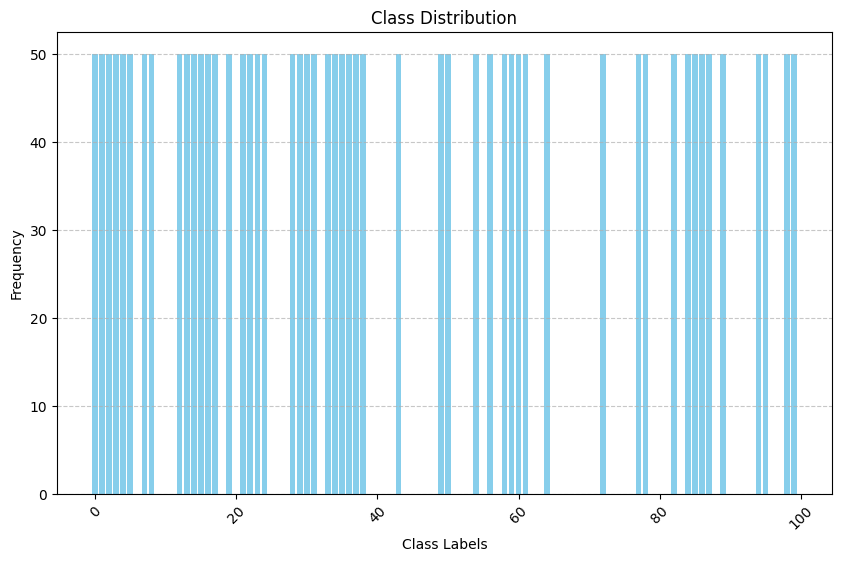

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

# Efficient counting with tqdm
label_counter = Counter()

for sample in tqdm(dataset, desc="Processing Labels"):
    label_counter[sample['label']] += 1

# Extract unique labels and their counts
unique = list(label_counter.keys())
counts = list(label_counter.values())

# Plotting the class distribution
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


Processing Labels: 100%|██████████| 2080/2080 [03:51<00:00,  8.98it/s]


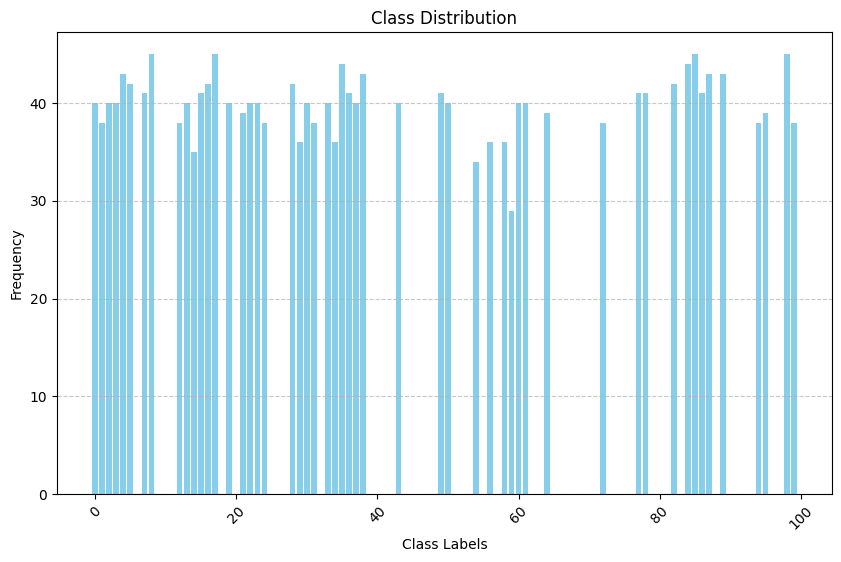

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

# Efficient counting with tqdm
label_counter = Counter()

for sample in tqdm(train_dataset, desc="Processing Labels"):
    label_counter[sample['label']] += 1

# Extract unique labels and their counts
unique = list(label_counter.keys())
counts = list(label_counter.values())

# Plotting the class distribution
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


Processing Labels: 100%|██████████| 520/520 [01:00<00:00,  8.65it/s]


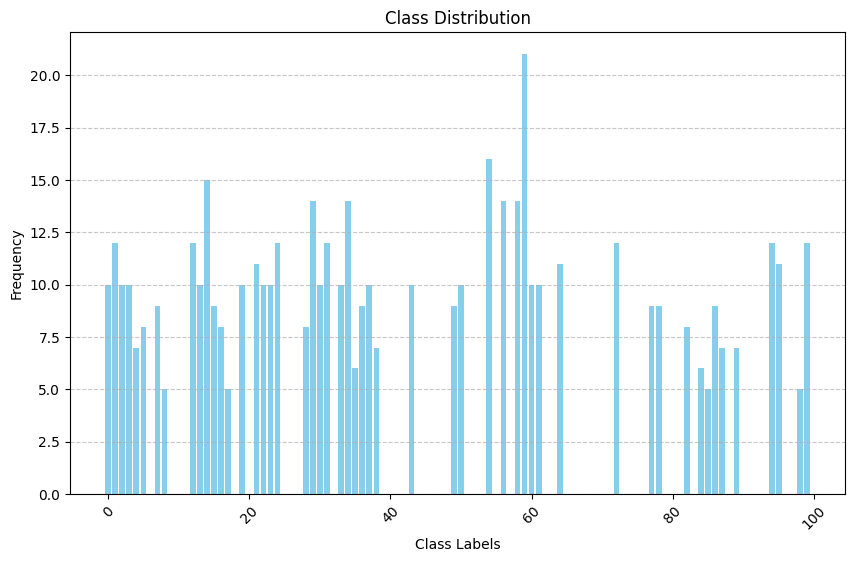

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

# Efficient counting with tqdm
label_counter = Counter()

for sample in tqdm(val_dataset, desc="Processing Labels"):
    label_counter[sample['label']] += 1

# Extract unique labels and their counts
unique = list(label_counter.keys())
counts = list(label_counter.values())

# Plotting the class distribution
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [ ]:
# DataLoaders
batch_size = 21
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
!curl https://www.dropbox.com/s/mdsa4t1xmcimia6/audioset_16_16_0.4422.pth?dl=1

zsh:1: no matches found: https://www.dropbox.com/s/mdsa4t1xmcimia6/audioset_16_16_0.4422.pth?dl=1


In [ ]:
# import torch
# torch.cuda.empty_cache()
# torch.cuda.empty_cache()
# torch.cuda.ipc_collect()

In [ ]:
# Set up model parameters (adjust num_classes according to your dataset).
num_classes = 101    # For example, if you have 10 classes.
num_latents = 256   # This should match your intended latent count (e.g., number of tokens).
dim = 768

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)
model = AVmodel(num_classes, num_latents, dim).to(device)

using device: cuda


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(


In [ ]:
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()  # Adjust based on your task
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Settings
epochs = 50
early_stopping_patience = 5  # Stop if no improvement for 5 epochs

# CSV Logger
log_columns = ["epoch", "train_loss", "val_loss", "train_acc", "val_acc"]
log_df = pd.DataFrame(columns=log_columns)

# Early Stopping Variables
best_val_loss = float("inf")
patience_counter = 0

# Training Loop
for epoch in range(1, epochs + 1):
    model.train()
    train_loss, train_correct = 0.0, 0
    total_train_samples = 0

    # Use tqdm for the training loop and update the loss in the progress bar
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} - Training")
    for batch in train_loader_tqdm:
        inputs_audio = batch['audio'].to(device)
        inputs_video = batch['video'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs_audio, inputs_video)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        total_train_samples += labels.size(0)

        # Update the progress bar with the current batch loss
        train_loader_tqdm.set_postfix({"Batch Loss": f"{loss.item():.4f}"})

    train_loss /= total_train_samples
    train_acc = train_correct / total_train_samples

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    total_val_samples = 0
    with torch.no_grad():
        # Use tqdm for the validation loop
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} - Validation")
        for batch in val_loader_tqdm:
            inputs_audio = batch['audio'].to(device)
            inputs_video = batch['video'].to(device)
            labels = batch['label'].to(device)

            outputs = model(inputs_audio, inputs_video)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            total_val_samples += labels.size(0)

            # Update the progress bar with the current batch loss
            val_loader_tqdm.set_postfix({"Batch Loss": f"{loss.item():.4f}"})

    val_loss /= total_val_samples
    val_acc = val_correct / total_val_samples

    # Logging
    log_df.loc[len(log_df)] = [epoch, train_loss, val_loss, train_acc, val_acc]
    log_df.to_csv("training_log.csv", index=False)

    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

Epoch 1/50 - Training:  14%|█▍        | 14/100 [01:15<07:52,  5.50s/it, Batch Loss=4.3303]

In [ ]:
# Plotting Results
plt.figure(figsize=(10, 5))
plt.plot(log_df["epoch"], log_df["train_loss"], label="Train Loss")
plt.plot(log_df["epoch"], log_df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.savefig("loss_plot.png")
plt.show()